# SRISHTI'23 - Tutorial 07
## Introduction to Gradient Descent
#### Lab Coordinator: Shantanu Agrawal

In this lab session, we will try to understand about the **Gradient Descent** and some of the properties related to it as well. But before moving further, please look at the [Tutorial 6 notebook](https://colab.research.google.com/drive/113mi94ko2R1iy_st2v7tR1JRMHvXwfLC) to revisit the concepts of Linear Classifiers and Perceptron Learning Algorithms.

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is

*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$
Here, $\eta$ is learning rate and $\Delta J$ is the gradient of the weight as per the loss function.

Let's try to implement the gradient descent algorithm and undersatnd it simultaneoulsy in this lab.

In [ ]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random   

random.seed(42)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [19]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

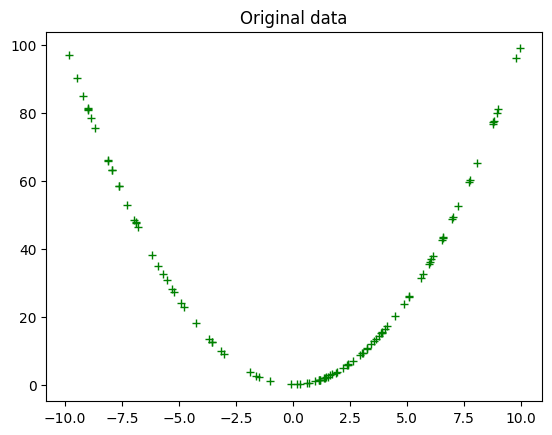

In [20]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [21]:

def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.
    
    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max 
    
    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it 
                                                  # give a number greater than the interval min. 
    
    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


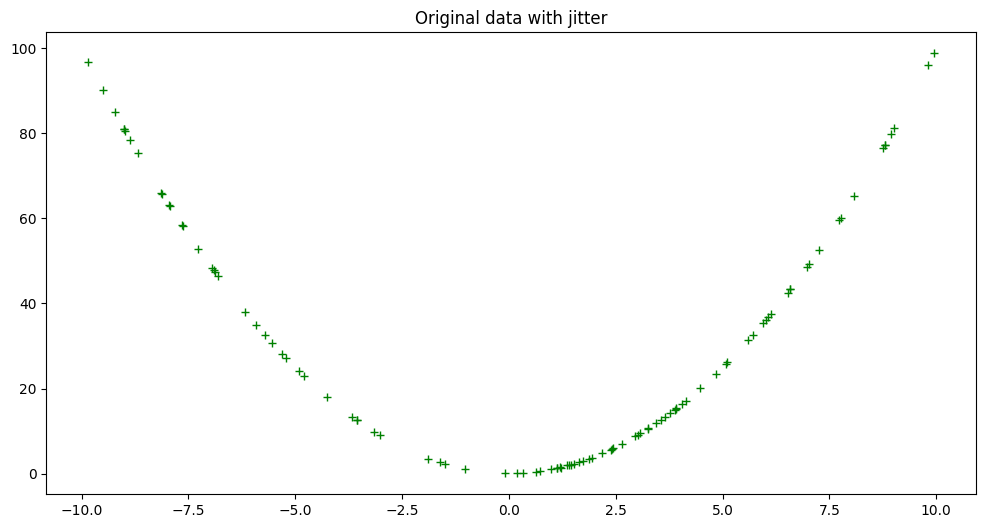

In [22]:

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

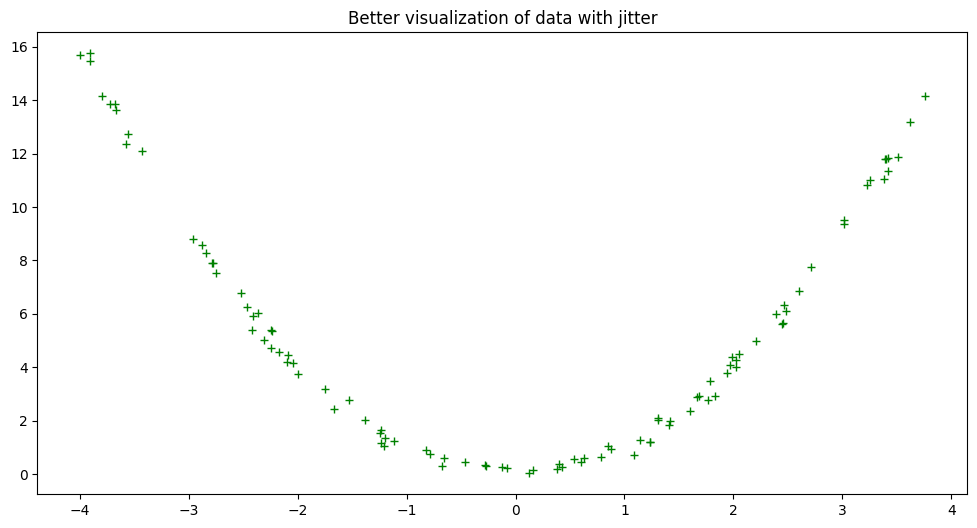

In [23]:
# To visulaize the jitter noise added in the data
# We try to simulate another set of x and y values

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)
  
plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [24]:

def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.
    
    Args:
        ys: training data labels
        y_bar: prediction labels
    
    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

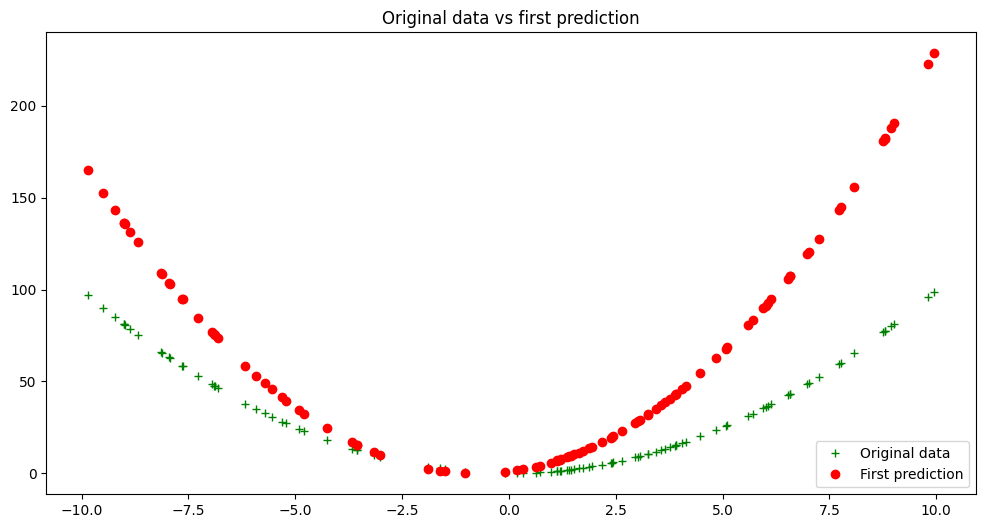

In [25]:

# First step, randomly predicting the coefficients  
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original data')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [26]:

initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

2153.5667491985096

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [27]:

def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    
    a_s = []
    b_s = []
    c_s = []
    
    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)
    
    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    # num = [i for i in y_bars]
    n = len(y_bars)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [28]:

# Second step, finding the gradient of the problem
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0001 # learning rate

# Continuing the second step
# Changing the coeffients in the negative direction of the gradient
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new) # New coeffients
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (1.6272553337428823, 2.9829725228223563, 0.9931511975651633)
Now have smaller model loss: 1020.0579956663248 vs 2153.5667491985096


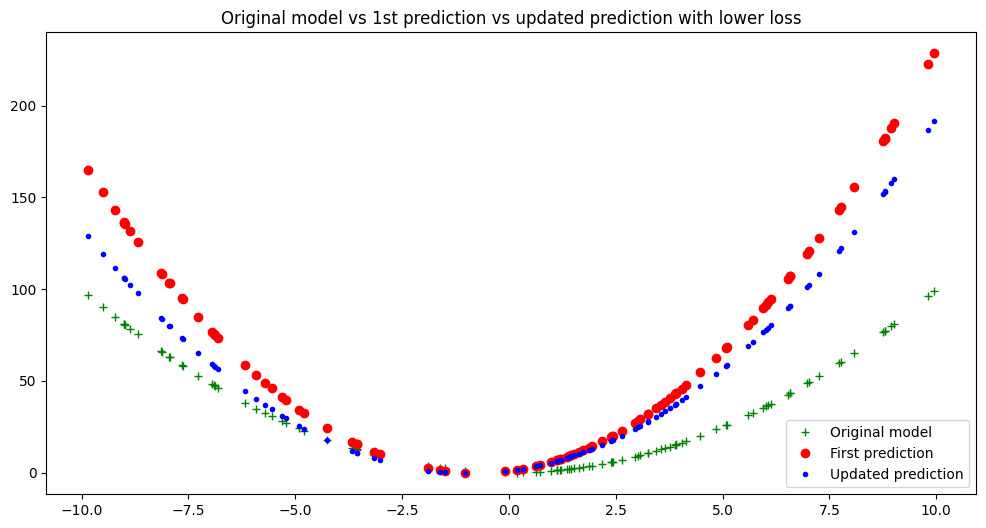

In [29]:

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original model')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'Updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [30]:

def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [31]:

def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.
    
    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss. 
        lr: specified learning rate
        
    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)
    
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    # Third step, Here we are fixing the number of times, we are running the problem
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

[308.51360522624486, 271.49748557655283, 260.8270046181631, 250.9200464948789, 241.39485869623158, 232.23186556134803, 223.41722455020218, 214.93769097781257, 206.78052472275712, 198.933470032129, 191.38473709229223, 184.12298431459763, 177.1373012947698, 170.41719242014358, 163.95256110012278, 157.73369459616362, 151.75124942849243, 145.99623733763022, 140.46001177963225, 135.13425493475077, 130.0109652100029, 125.08244521686538, 120.34129020603312, 115.78037694186534, 111.3928529998022, 107.17212647067299, 103.11185605642513, 99.20594154239353, 95.44851463179587, 91.83393012868129, 88.35675745608573, 85.0117724966499, 81.79394974344065, 78.69845474918235, 75.72063686255345, 72.85602224063365, 70.10030712700484, 67.44935138540428, 64.8991722792157, 62.445938487451585, 60.08596434823562, 57.81570432113625, 55.63174766003193, 53.53081328850194, 51.509744870046, 49.56550606572306, 47.695175972086055, 45.895944732556316, 44.165109315645374, 42.500069453680005, 40.89832373592868, 39.357465

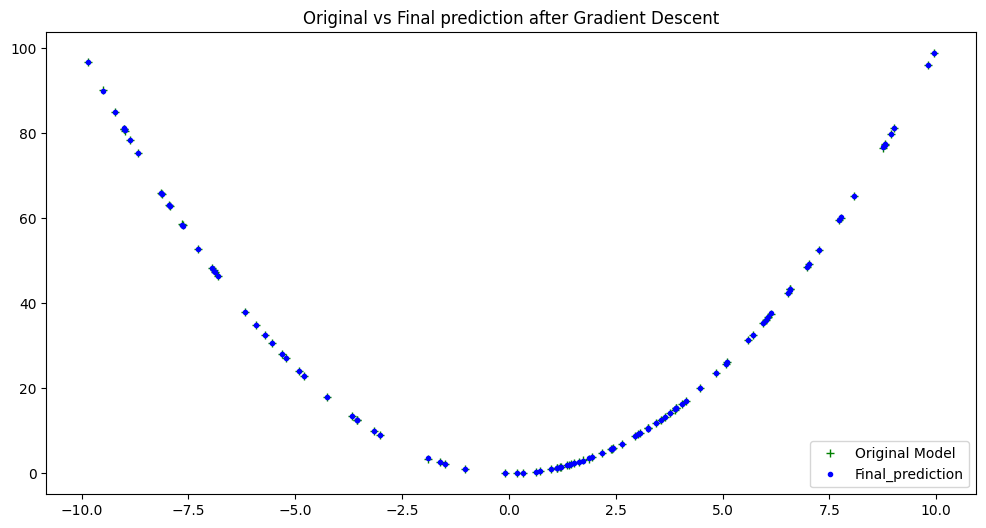

In [32]:

GD = gradient_descent(30000, 0.0003)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [33]:

print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (1.0000060835497007, 0.00014234689489686883, -0.00606713574024877)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 2153.5667491985096
Loss calculated after last epoch: 0.0027993415230919113


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


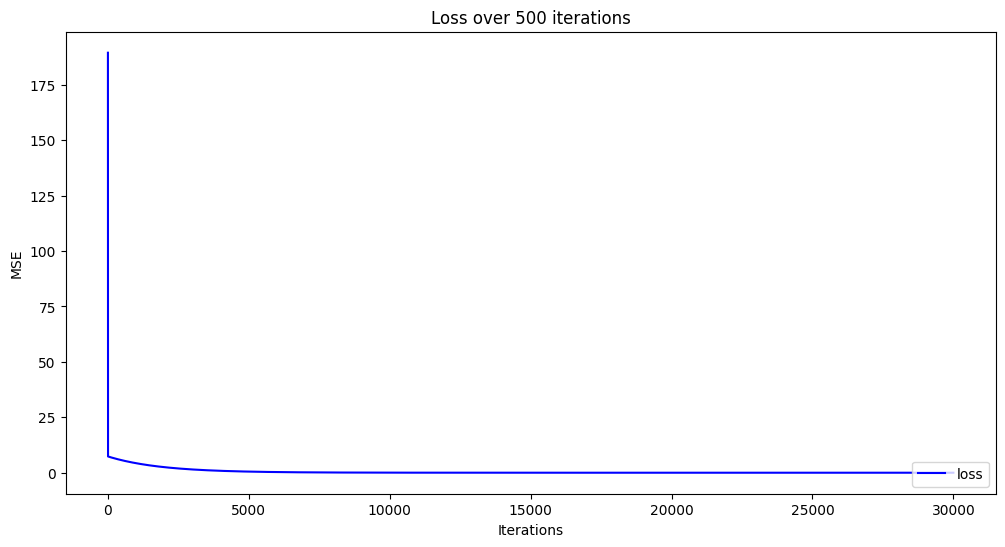

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss within about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached (another form of convergance criteria, which can be used for third step). This would prevent excessive training and potential over-fitting for the model.

NOTES:
- Please try to think on the mentioned questions first, apply on your own if possible rather than directly accessing the links. 
- But make sure, you do go through the given links at once. You can leave the discussion about the topics which are not known to you, if found difficult to understand.
<br><br>
# Things to try
1. Change the values of parameters in the functions and observe the changes in  the result.
1. Change the coefficients array and try a different polynomial instead of our $x^2$.
2. Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
  - https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/#:~:text=When%20the%20learning%20rate%20is,with%20a%20high%20training%20error.
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
  - This will help you understand the concepts of convex and non-convex optimization problems and will introduce you to the concept of local minima.
  - https://towardsdatascience.com/understand-convexity-in-optimization-db87653bf920
  - https://stats.stackexchange.com/questions/172900/can-gradient-descent-be-applied-to-non-convex-functions
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?
  - https://towardsdatascience.com/minimizing-the-cost-function-gradient-descent-a5dd6b5350e1
5. Try to compare gradient descent algorithm with your understanding on perceptron learning algorithm?
  - https://stats.stackexchange.com/questions/137834/clarification-about-perceptron-rule-vs-gradient-descent-vs-stochastic-gradient
6. Now, since we know about both SVMs and Gradient Descent. Can Gradient Descent be used in for SVM Formulation?
  - https://towardsdatascience.com/solving-svm-stochastic-gradient-descent-and-hinge-loss-8e8b4dd91f5b



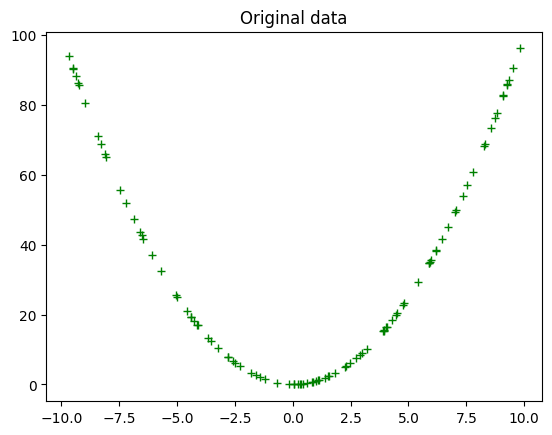

In [44]:
#1 
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y


def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.
    
    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max 
    
    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it 
                                                  # give a number greater than the interval min. 
    
    return jit_val

def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.
    
    Args:
        ys: training data labels
        y_bar: prediction labels
    
    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

xs = []
ys = []
for x in hundred_xs:
    y = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()


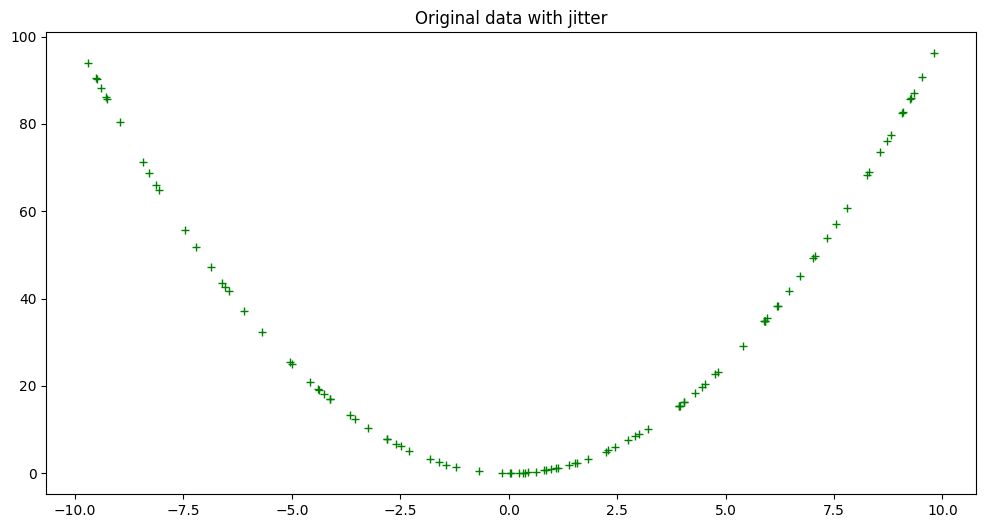

In [45]:

xs = []
ys = []
for x in hundred_xs:
    y = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()


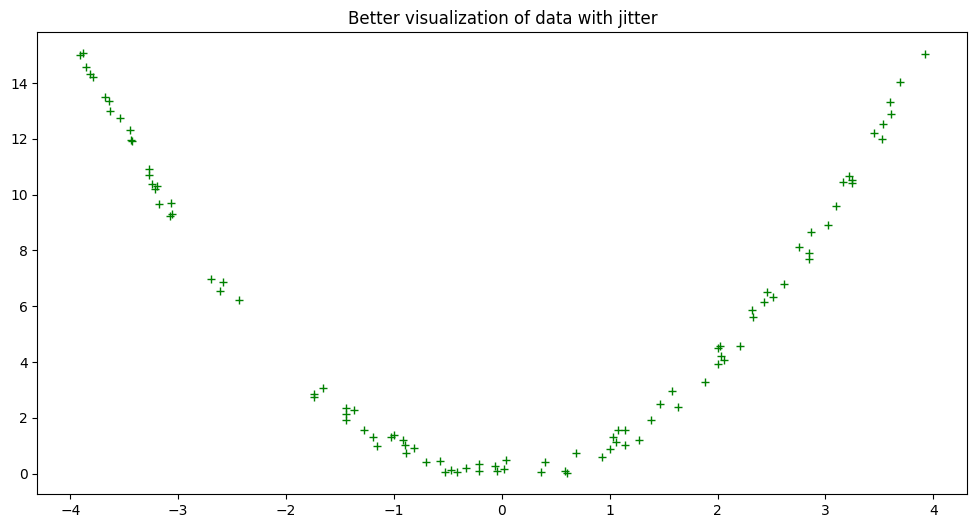

In [46]:

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y = eval_2nd_degree_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

In [47]:

def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    
    a_s = []
    b_s = []
    c_s = []
    
    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)
    
    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    # num = [i for i in y_bars]
    n = len(y_bars)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts



def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.
    
    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss. 
        lr: specified learning rate
        
    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)
    
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    # Third step, Here we are fixing the number of times, we are running the problem
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

<ipython-input-44-066187e6c550>:65: RuntimeWarning: overflow encountered in double_scalars
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)
<ipython-input-44-066187e6c550>:65: RuntimeWarning: overflow encountered in multiply
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)


[3567103.4514126414, 5630286385.825958, 8886884840501.04, 1.4027123456991034e+16, 2.214051335300022e+19, 3.4946746782218377e+22, 5.516019846463938e+25, 8.706525713593938e+28, 1.3742443303583563e+32, 2.1691172135096376e+35, 3.423750334641649e+38, 5.404072348396734e+41, 8.529826971090415e+44, 1.3463540727452897e+48, 2.1250950287050278e+51, 3.3542653990108205e+54, 5.294396822271673e+57, 8.356714325570846e+60, 1.319029847279883e+64, 2.081966273145687e+67, 3.28619065857757e+70, 5.1869471584695555e+73, 8.187114997278025e+76, 1.2922601663524978e+80, 2.0397128147052902e+83, 3.2194974934622464e+86, 5.0816781831648855e+89, 8.020957683518298e+92, 1.266033775494274e+96, 1.998316889248593e+99, 3.1541578646250157e+102, 4.978545639333894e+105, 7.858172528684512e+108, 1.2403396486455418e+112, 1.9577610931630811e+115, 3.0901443020777184e+118, 4.87750616814814e+121, 7.698691094887521e+124, 1.215166983520263e+128, 1.918028376042158e+131, 3.027429893334965e+134, 4.778517290745603e+137, 7.542446333183581e+

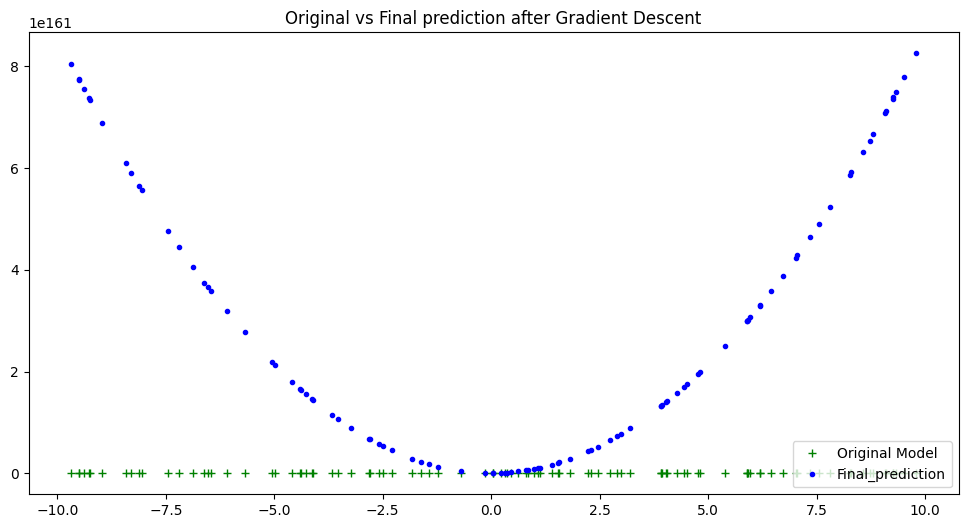

In [48]:

GD = gradient_descent(100, 0.01)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

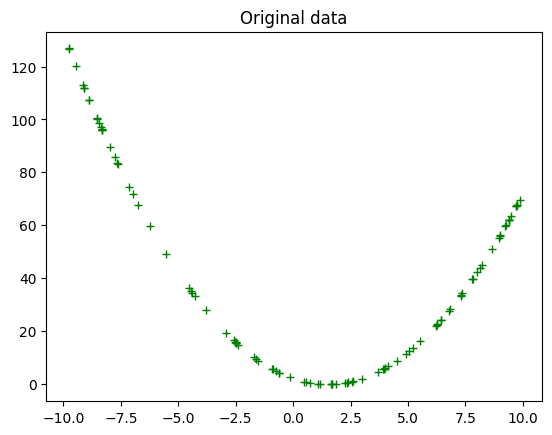

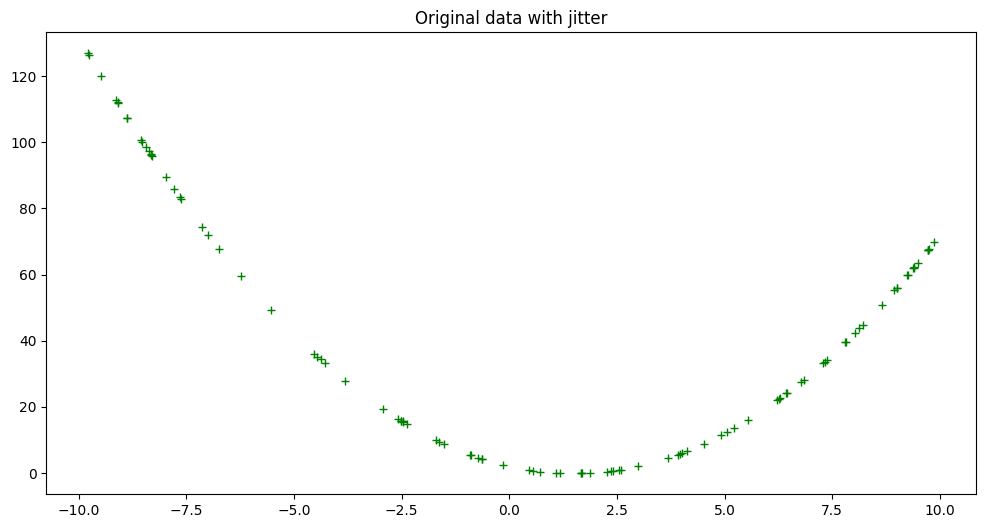

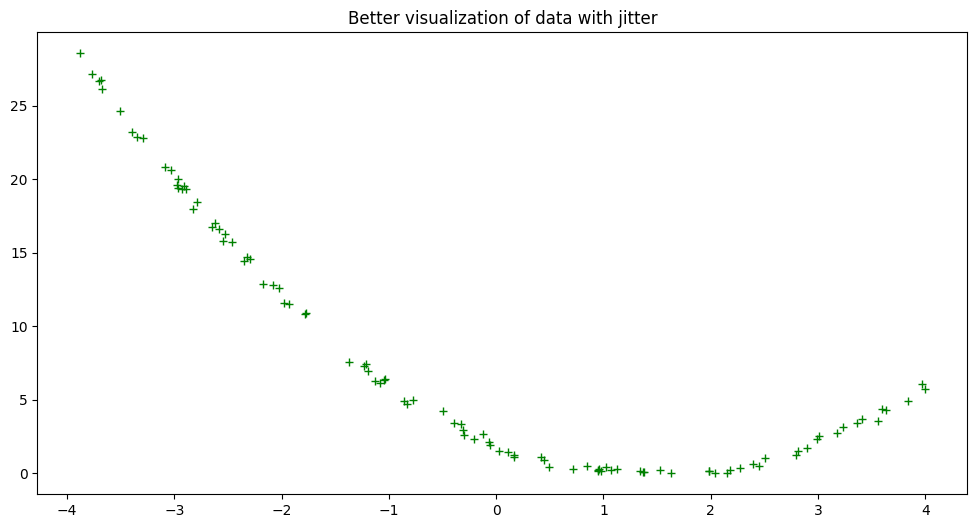

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-49-43ff4b933d01>:32: RuntimeWarning: overflow encountered in square
  return np.sum((ys - y_bar) ** 2) / len(ys)


Optimized coefficients:  [2.00000000e+000 1.27411828e+199 1.50583149e+201]


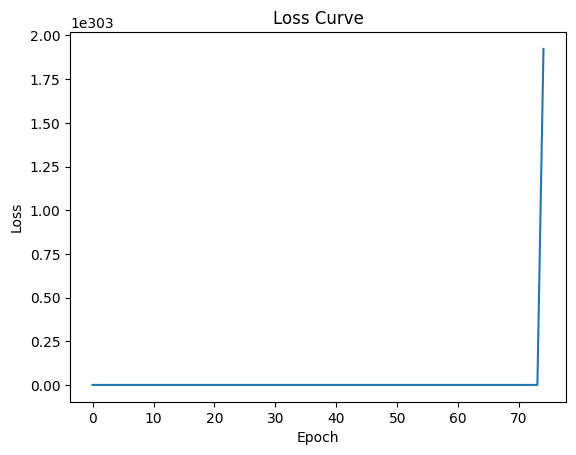

In [49]:
#2
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)

def eval_polynomial(coeffs, x):
    # Function to return the output of evaluating a polynomial, given a specific x value.
    y = sum(coeff * (x ** i) for i, coeff in enumerate(coeffs))
    return y

def eval_polynomial_jitter(coeffs, x, j):
    # Function to return the noisy output of evaluating a polynomial, given a specific x value.
    # Output values can be within [y − j, y + j].
    y = eval_polynomial(coeffs, x)
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max

    while interval_min > jit_val:
        jit_val = random.random() * interval_max
    
    return jit_val

def loss_mse(ys, y_bar):
    # Calculates MSE loss.
    ys = np.array(ys)
    y_bar = np.array(y_bar)
    return np.sum((ys - y_bar) ** 2) / len(ys)

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [2, -3, 1]

xs = []
ys = []
for x in hundred_xs:
    y = eval_polynomial(coeffs, x)
    xs.append(x)
    ys.append(y)

plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

xs = []
ys = []
for x in hundred_xs:
    y = eval_polynomial_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y = eval_polynomial_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

def calc_gradient_polynomial(coeffs, hundred_xs, ys): 
    # Calculates the gradient for a polynomial.
    degree = len(coeffs) - 1
    gradient = np.zeros(degree + 1)
    
    for i in range(len(hundred_xs)):
        x = hundred_xs[i]
        y = ys[i]
        
        polynomial = [x ** j for j in range(degree + 1)]
        derivatives = [j * (x ** j) for j in range(degree + 1)]
        
        gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
    
    gradient /= len(hundred_xs)
    
    return gradient

def gradient_descent(coeffs, hundred_xs, ys, lr, epochs):
    # Performs gradient descent optimization to find the best coefficients for a polynomial.
    losses = []
    coeffs = np.array(coeffs, dtype=np.float64)
    
    for epoch in range(epochs):
        gradient = calc_gradient_polynomial(coeffs, hundred_xs, ys)
        coeffs -= lr * gradient
        loss = loss_mse(ys, [eval_polynomial(coeffs, x) for x in hundred_xs])
        losses.append(loss)
    
    return coeffs, losses

learning_rate = 0.01
num_epochs = 100

final_coeffs, losses = gradient_descent(coeffs, hundred_xs, ys, learning_rate, num_epochs)

print("Optimized coefficients: ", final_coeffs)

plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()


Optimized coefficients:  [2.00000000e+00 9.00300982e+60 1.06403117e+63]


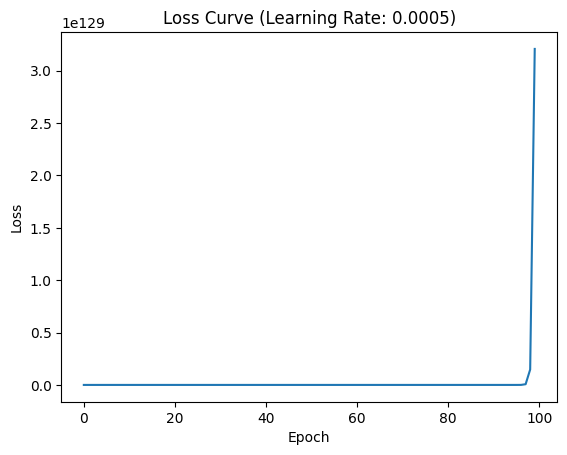

In [50]:
#3
learning_rate = 0.0005
num_epochs = 100

final_coeffs, losses = gradient_descent(coeffs, hundred_xs, ys, learning_rate, num_epochs)

print("Optimized coefficients: ", final_coeffs)

plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Learning Rate: 0.0005)")
plt.show()


<ipython-input-49-43ff4b933d01>:32: RuntimeWarning: overflow encountered in square
  return np.sum((ys - y_bar) ** 2) / len(ys)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: overflow encountered in add
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: overflow encountered in multiply
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: invalid value encountered in multiply
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: invalid value encountered in add
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:99: RuntimeWarning: invalid value encountered in subtract
  coeffs -= lr * gradient


Optimized coefficients:  [nan nan nan]


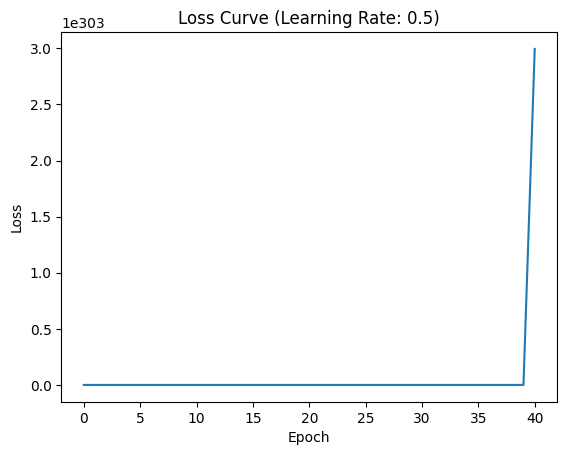

In [51]:
learning_rate = 0.5
num_epochs = 100

final_coeffs, losses = gradient_descent(coeffs, hundred_xs, ys, learning_rate, num_epochs)

print("Optimized coefficients: ", final_coeffs)

plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Learning Rate: 0.5)")
plt.show()


<ipython-input-49-43ff4b933d01>:32: RuntimeWarning: overflow encountered in square
  return np.sum((ys - y_bar) ** 2) / len(ys)
<ipython-input-49-43ff4b933d01>:10: RuntimeWarning: overflow encountered in double_scalars
  y = sum(coeff * (x ** i) for i, coeff in enumerate(coeffs))
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: invalid value encountered in multiply
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: invalid value encountered in add
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: overflow encountered in multiply
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)
<ipython-input-49-43ff4b933d01>:86: RuntimeWarning: overflow encountered in double_scalars
  gradient += 2 * (np.dot(coeffs, polynomial) - y) * np.array(derivatives)


Optimized coefficients:  [nan nan nan nan nan nan]


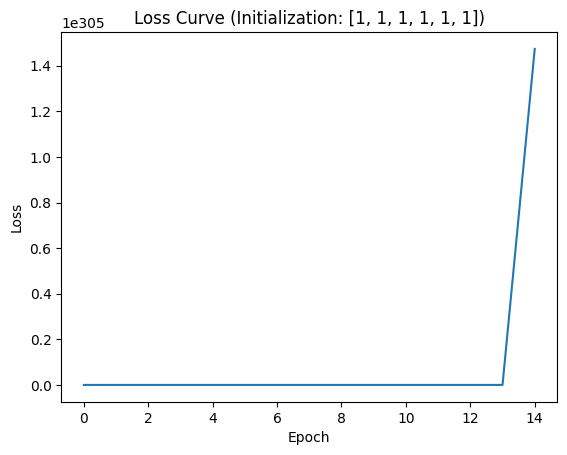

Optimized coefficients:  [nan nan nan nan nan nan]


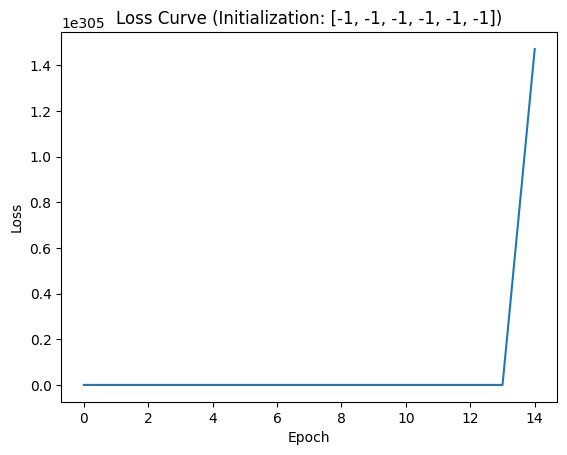

Optimized coefficients:  [nan nan nan nan nan nan]


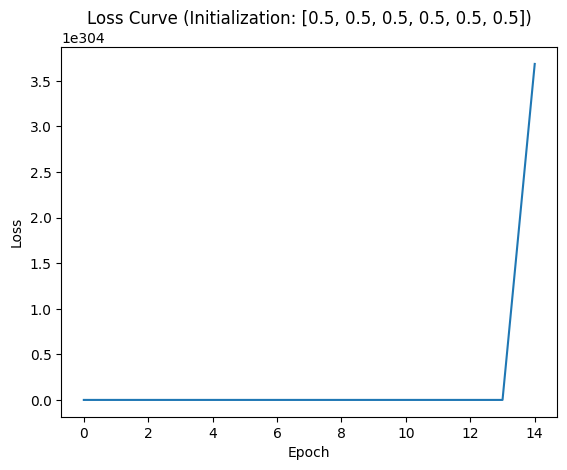

In [52]:
#4
# Set the initial coefficients with different initializations
init_coeffs = [[1, 1, 1, 1, 1, 1], [-1, -1, -1, -1, -1, -1], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]

for init_coeff in init_coeffs:
    final_coeffs, losses = gradient_descent(init_coeff, hundred_xs, ys, learning_rate, num_epochs)

    print("Optimized coefficients: ", final_coeffs)

    plt.plot(range(num_epochs), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve (Initialization: {})".format(init_coeff))
    plt.show()


<ipython-input-54-0cf94a139a9c>:24: RuntimeWarning: overflow encountered in square
  return np.sum((ys - y_bar) ** 2) / len(ys)
<ipython-input-54-0cf94a139a9c>:17: RuntimeWarning: overflow encountered in add
  gradient += 2 * (np.dot(coeffs, derivatives) - y) * np.array(derivatives)
<ipython-input-54-0cf94a139a9c>:17: RuntimeWarning: invalid value encountered in add
  gradient += 2 * (np.dot(coeffs, derivatives) - y) * np.array(derivatives)


Optimized coefficients:  [nan nan nan]


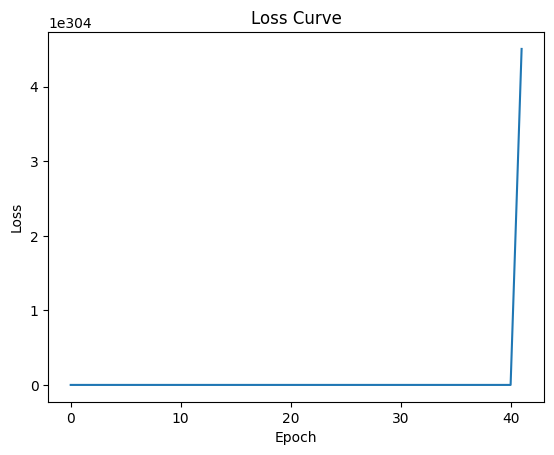

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_ascent(coeffs, xs, ys, lr, epochs):
    losses = []
    for epoch in range(epochs):
        gradient = calc_gradient_polynomial(coeffs, xs, ys)
        coeffs += lr * gradient  # Update the coefficients with positive gradient
        loss = loss_mse(ys, np.array([eval_polynomial(coeffs, x) for x in xs]))
        losses.append(loss)
    return coeffs, losses

def calc_gradient_polynomial(coeffs, xs, ys):
    gradient = np.zeros_like(coeffs, dtype=np.float64)
    for x, y in zip(xs, ys):
        derivatives = [x ** i for i in range(len(coeffs))]
        gradient += 2 * (np.dot(coeffs, derivatives) - y) * np.array(derivatives)
    return gradient

def eval_polynomial(coeffs, x):
    return np.dot(coeffs, [x ** i for i in range(len(coeffs))])

def loss_mse(ys, y_bar):
    return np.sum((ys - y_bar) ** 2) / len(ys)

# Generate random data
np.random.seed(42)
hundred_xs = np.random.uniform(-10, 10, 100)
ys = [x ** 2 + np.random.normal(0, 5) for x in hundred_xs]  # Quadratic function with noise

# Set the initial coefficients
coeffs = np.array([1, 1, 1], dtype=np.float64)

learning_rate = 0.01
num_epochs = 100

# Perform gradient ascent
final_coeffs, losses = gradient_ascent(coeffs, hundred_xs, ys, learning_rate, num_epochs)

print("Optimized coefficients: ", final_coeffs)

plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()


In [ ]:
#6
#The objective of gradient descent is to minimize a given loss function, typically associated with a regression problem whereas, the perceptron learning algorithm 
#aims to find a decision boundary that separates two classes in a classification problem. Gradient descent optimizes a continuous and differentiable loss function, such as mean squared error (MSE) or mean absolute error (MAE).
#The perceptron learning algorithm uses a simple error function that is based on misclassification, where the error is only updated when a misclassification occurs.
#Gradient descent adjusts the model weights or coefficients in the direction of steepest descent of the loss function whereas the perceptron learning algorithm updates the weights only when misclassifications occur


In [ ]:
#7
#Yes, gradient descent can be used for optimizing the parameters of a Support Vector Machine (SVM). The SVM formulation involves finding the optimal hyperplane
#that separates the data points of different classes while maximizing the margin. This is typically formulated as a constrained optimization problem, where the 
#objective is to minimize a loss function subject to certain constraints